In [20]:
import sys
sys.path.append("./wlevel_estimator/")

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import json

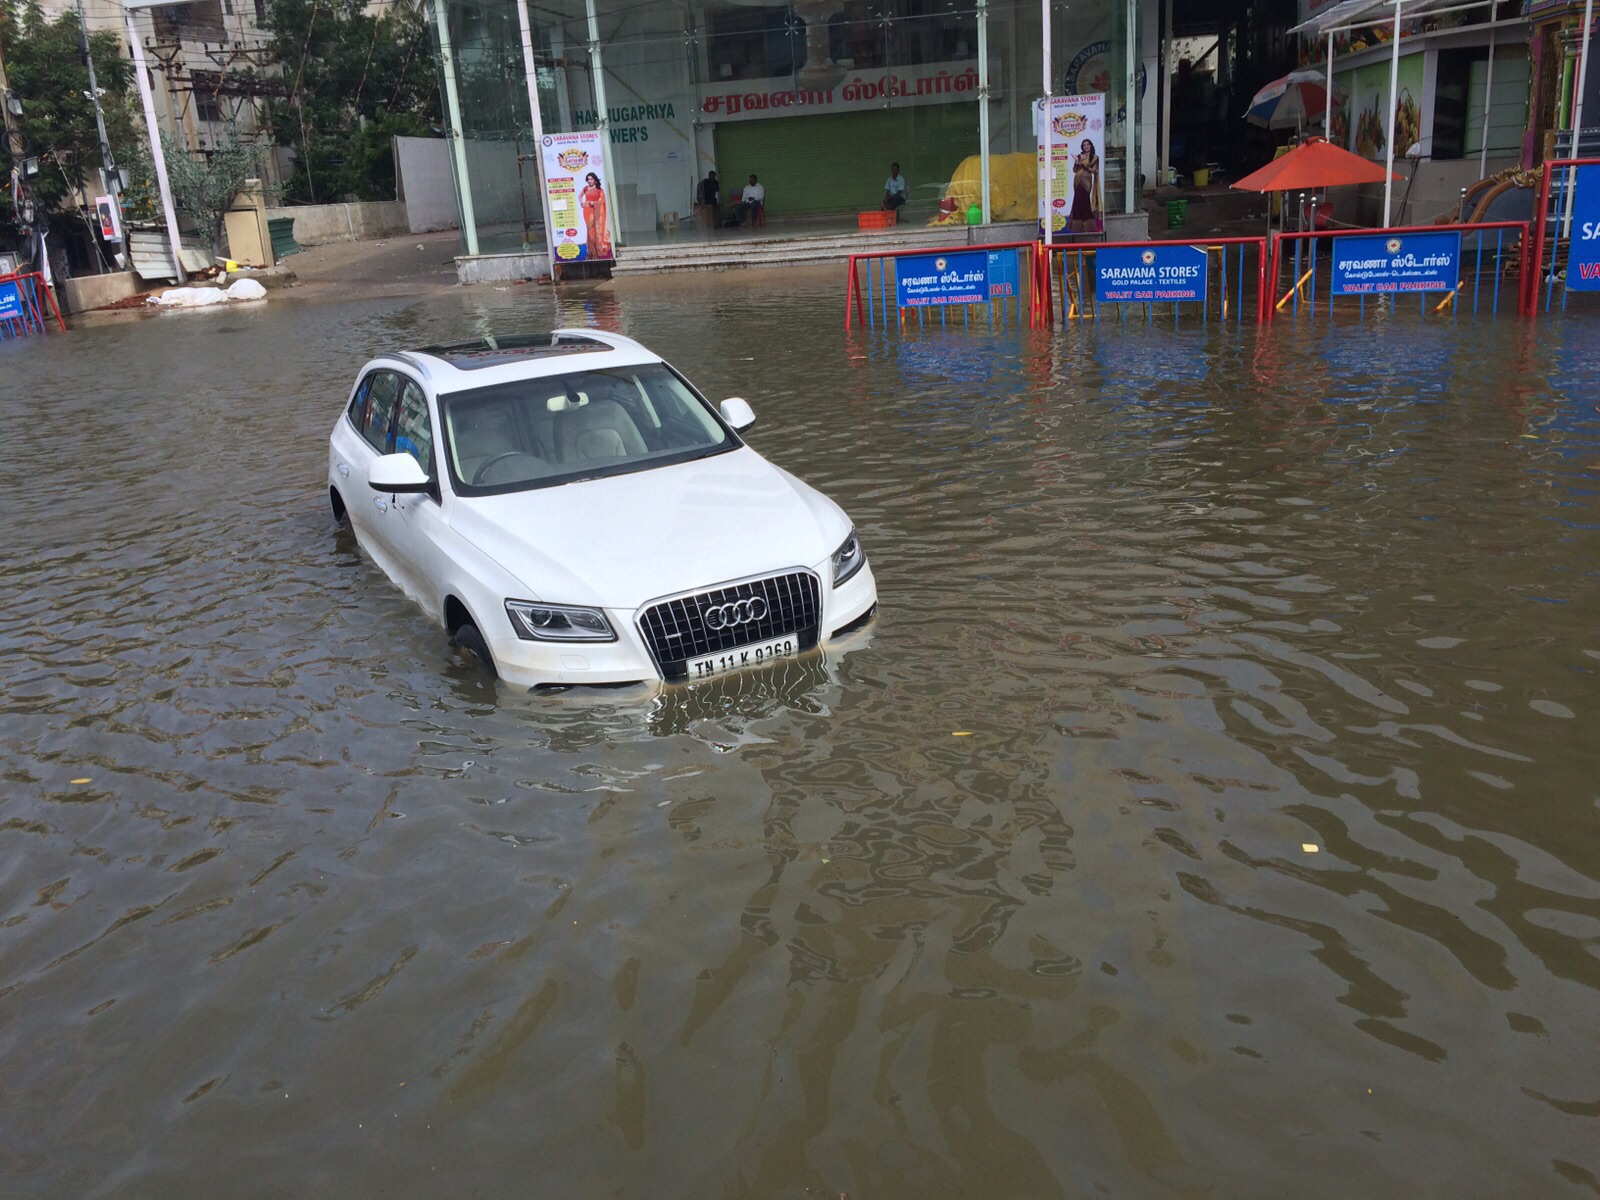

In [21]:
image_folder = "./images/Flood/"
file_names = os.listdir(image_folder)
image_name = "Flood_1344.jpg"
pil_image = Image.open(image_folder+image_name)
im_width, im_height = pil_image.size
np_image = np.array(pil_image)
pil_image

In [3]:
image_name

'Flood_103.jpg'

In [22]:
from wlevel_estimator import WaterLevelEstimator

estimator = WaterLevelEstimator()
estimator.process(np_image)
cars = estimator.get_cars()

[Message] Start mask detecion process
[Message] End mask detecion process
[Message] Start Keypoint detection process
	[Message] Start process car 0
		[Message] Image Segment need to be resized
		[Message] detected 20 keypoints with square size 512
		[Message] Half the keypoint detection window to 256.0
		[Message] Image Segment need to be resized
		[Message] detected 17 keypoints with square size 256.0
[Message] solve pnp using ITERATIVE
[Message] solve pnp using ITERATIVE
[Data] Water Level: 1.5689043038000001 meter.


In [23]:
from wlevel_estimator.data.vehicle import VehicleType

def load_mesh(car_type:VehicleType):

    if car_type == VehicleType.SEDAN:
        type_str = "sedan"
    elif car_type == VehicleType.SUV:
        type_str = "suv"

    with open("./mesh/"+type_str+"_keypts.txt") as file:
        keypoints_list = []
        
        for line in file.readlines():
            line = line.strip('\n')
            x,y,z = line.split()
            keypoints_list.append([float(x),float(y),float(z)])
        keypoints_3D = np.array(keypoints_list,dtype="float")

    with open("./mesh/"+type_str+".json") as json_file:
        car_model = json.load(json_file)
        vertices = np.array(car_model['vertices'])  # x: w y: h z: l
        triangles = np.array(car_model['faces']) - 1

    return keypoints_3D,vertices,triangles

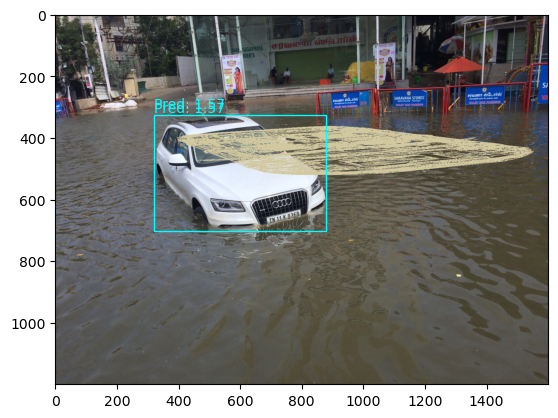

In [24]:
from wlevel_estimator.project import camera_matrix, dist_coeffs, draw_obj, draw_obj_mask

def water_rising(vertices,water_level):
    top = np.max(vertices,0)[1]
    bottom = np.min(vertices,0)[1]

    bottom = bottom + water_level
    new_vertices = vertices.copy() # x: w y: h z: l

    for i_v, v in enumerate(new_vertices):
        if v[1] >= top - water_level:
            new_vertices[i_v][1] = top - water_level
            new_vertices[i_v][0] = v[0]
            new_vertices[i_v][2] = v[2]
        else:
            new_vertices[i_v] = v

    return new_vertices

show_img = np_image.copy()

car_amount = len(cars)

fig = plt.figure()
ax = fig.gca()

for car in cars:

    (x1,y1,x2,y2) = car.original_box
    plt.text(int(x1), int(y1-20), f"Pred: {round(car.water_level,2)}",color = "cyan",fontsize=10)
    plt.text(int(x1), int(y1-10), f"Pred: {round(car.water_level,2)}",color = "cyan",fontsize=10)
    rect = patches.Rectangle((int(x1), int(y1)), int(x2-x1), int(y2-y1), fill=False, edgecolor = 'cyan',linewidth=1)
    ax.add_patch(rect)

    # for kpt,kpt_id in zip(car.original_keypoints,car.keypoints_id):
    #     plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
    #     plt.text(int(kpt[0]), int(kpt[1]), str(kpt_id),color = "ivory",fontsize=10)

    keypoints_3D,vertices,triangles = load_mesh(car.type)
    (rotation_vector,translation_vector) =  car.transform
    new_vertices =  water_rising(vertices,car.water_level)

    (projected_vertices, _) = cv2.projectPoints(new_vertices, 
                                                rotation_vector, 
                                                translation_vector,
                                                camera_matrix, 
                                                dist_coeffs)

    draw_obj(show_img,projected_vertices,triangles,(210,200,160))

plt.imshow(show_img)
plt.show()

In [14]:
round(car.water_level,2)

0.67